In [1]:
#combine files 
import glob 
import os
#clean 
import string
import pandas as pd
import numpy as np
import emoji
import nltk
import re 
from cleantext import clean
#sleep timer 
import time 
import logging
import threading
#show most common words
from collections import Counter
#word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('J&TExpressJakarta .csv')
#only keep caption column 
df1 = df[['caption']]
df1 = df1.dropna()

In [3]:
df1['middle'] = df1['caption'].str.split(")").str[1] 
df1['reviews'] = df1['middle'].str.split("(").str[0]

df1 = df1.reset_index()

In [4]:
df1['reviews'].fillna('0', inplace = True)
for i, row in df1.iterrows(): 
    review = row['reviews']
    if review == '0':
        df1['reviews'][i] = review.replace('0', row['caption'])

/var/folders/5w/0kxl7gbj5vqb93sccvkxwrzc0000gn/T/ipykernel_42434/1854476216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews'][i] = review.replace('0', row['caption'])


In [5]:
df1 = df1.rename(columns={'reviews': 'Reviews'})
df1

,index,caption,middle,Reviews
0,1,"Pengiriman jauh melebihi batas waktu, manajeme...",NaN,"Pengiriman jauh melebihi batas waktu, manajeme..."
1,2,worst of the worst! DO NOT USE them as your co...,NaN,worst of the worst! DO NOT USE them as your co...
2,6,(Translated by Google) Good (Original) Baik,Good (Original,Good
3,7,(Translated by Google) the call center on what...,the call center on whatsapp was answered by B...,the call center on whatsapp was answered by B...
4,8,(Translated by Google) Why was my J&T notified...,Why was my J&T notified that my package had a...,Why was my J&T notified that my package had a...
...,...,...,...,...
777,1009,(Translated by Google) Because j & t express i...,Because j & t express is delivering goods rig...,Because j & t express is delivering goods rig...
778,1011,(Translated by Google) My niece's package hasn...,"My niece's package hasn't arrived until now, ...","My niece's package hasn't arrived until now, ..."
779,1015,(Translated by Google) The location is easy to...,The location is easy to find ' (Original,The location is easy to find '
780,1016,"(Translated by Google) Great service, bro ... ...","Great service, bro ... (Original","Great service, bro ..."


In [6]:
df1['Reviews'].to_csv('jnt1.csv')

### Clean the data

In [7]:
df_combi = pd.read_csv('jnt1.csv')

from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and lemmatize/stem.'''
    text = str(text).lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = clean(text, no_emoji=True)
    text = emoji.demojize(text, delimiters=("", "")) #change emoji into text 
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df_combi['clean_1'] = pd.DataFrame(df_combi['Reviews'].apply(clean_text_round1))
df_combi

,Unnamed: 0,Reviews,clean_1
0,0,"Pengiriman jauh melebihi batas waktu, manajeme...",pengiriman jauh melebihi batas waktu manajemen...
1,1,worst of the worst! DO NOT USE them as your co...,worst worst use courier youll regret later unp...
2,2,Good,good
3,3,the call center on whatsapp was answered by B...,call center whatsapp answered bot email custom...
4,4,Why was my J&T notified that my package had a...,jt notified package arrived wasnt place explai...
...,...,...,...
777,777,Because j & t express is delivering goods rig...,j express delivering goods right fast safe god...
778,778,"My niece's package hasn't arrived until now, ...",nieces package hasnt arrived even though sent ...
779,779,The location is easy to find ',location easy find
780,780,"Great service, bro ...",great service bro


### Sentiment analysis 


In [8]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
def clean_text_round2(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output
df_combi['clean_2'] = pd.DataFrame(df_combi['clean_1'].apply(clean_text_round2))


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    if sentiment_dict['compound'] >= 0.05 : 
       return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
       return "Neutral"
        
df_combi['sentiment'] = pd.DataFrame(df_combi['Reviews'].apply(sentiment_scores))

In [10]:
df_combi

,Unnamed: 0,Reviews,clean_1,clean_2,sentiment
0,0,"Pengiriman jauh melebihi batas waktu, manajeme...",pengiriman jauh melebihi batas waktu manajemen...,pengiriman jauh melebihi bata waktu manajemenn...,Neutral
1,1,worst of the worst! DO NOT USE them as your co...,worst worst use courier youll regret later unp...,worst worst use courier youll regret later unp...,Negative
2,2,Good,good,good,Positive
3,3,the call center on whatsapp was answered by B...,call center whatsapp answered bot email custom...,call center whatsapp answered bot email custom...,Neutral
4,4,Why was my J&T notified that my package had a...,jt notified package arrived wasnt place explai...,jt notified package arrived wasnt place explai...,Neutral
...,...,...,...,...,...
777,777,Because j & t express is delivering goods rig...,j express delivering goods right fast safe god...,j express delivering good right fast safe god ...,Positive
778,778,"My niece's package hasn't arrived until now, ...",nieces package hasnt arrived even though sent ...,niece package hasnt arrived even though sent m...,Neutral
779,779,The location is easy to find ',location easy find,location easy find,Positive
780,780,"Great service, bro ...",great service bro,great service bro,Positive


In [11]:
df_neg = df_combi.drop(df_combi[df_combi['sentiment'] != 'Negative'].index)
df_neg = df_neg[['clean_2']]
df_neg

,clean_2
1,worst worst use courier youll regret later unp...
5,slow work item ordered still even delivery att...
6,noticed google play google map assessment jt b...
7,delivery service clear irritates sender recipi...
8,jt delivery service removed package item nomin...
...,...
762,star ckckckcck service jt palm cakeng jakbar r...
767,worst shipping expectoration item hasnt said a...
768,possible wont even give star package batam ban...
770,wont take long dont know obstacle delivery doe...


In [12]:
#combining the text into one long string for word cloud 
cloud_string = df_neg['clean_2'].str.cat(sep=' ')

In [13]:
# Let's first pull out the top 30 words for each category
words = []
for word in cloud_string.split():
        words.append(word)
Counter(words).most_common()

[('...', 332),
 ('package', 158),
 ('service', 136),
 ('day', 122),
 ('good', 102),
 ('bad', 99),
 ('arrived', 82),
 ('delivery', 80),
 ('jakarta', 72),
 ('even', 69),
 ('jt', 68),
 ('time', 63),
 ('sent', 62),
 ('use', 59),
 ('really', 52),
 ('courier', 51),
 ('expedition', 49),
 ('though', 49),
 ('item', 45),
 ('still', 44),
 ('arrive', 42),
 ('long', 41),
 ('j', 41),
 ('disappointed', 39),
 ('hasnt', 37),
 ('warehouse', 36),
 ('shipping', 33),
 ('jnt', 32),
 ('worst', 30),
 ('using', 30),
 ('didnt', 30),
 ('week', 28),
 ('c', 28),
 ('call', 28),
 ('send', 28),
 ('slow', 27),
 ('dont', 27),
 ('address', 27),
 ('express', 26),
 ('received', 24),
 ('phone', 24),
 ('want', 23),
 ('center', 23),
 ('already', 23),
 ('star', 23),
 ('customer', 22),
 ('tangerang', 21),
 ('doesnt', 21),
 ('take', 20),
 ('stuck', 19),
 ('yet', 19),
 ('status', 19),
 ('many', 18),
 ('disappointing', 18),
 ('come', 18),
 ('worse', 17),
 ('severe', 17),
 ('give', 17),
 ('lost', 16),
 ('clear', 15),
 ('know', 15)

In [14]:
#add meaningless words to stopwords
add_stop_words = ['...' , 'call', 'dont', 'cant']
stop_words = add_stop_words + stop 

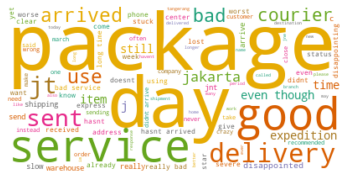

In [15]:
#wordcloud for top 100 words 
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, max_words = 100)

wordcloud = wc.generate(cloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

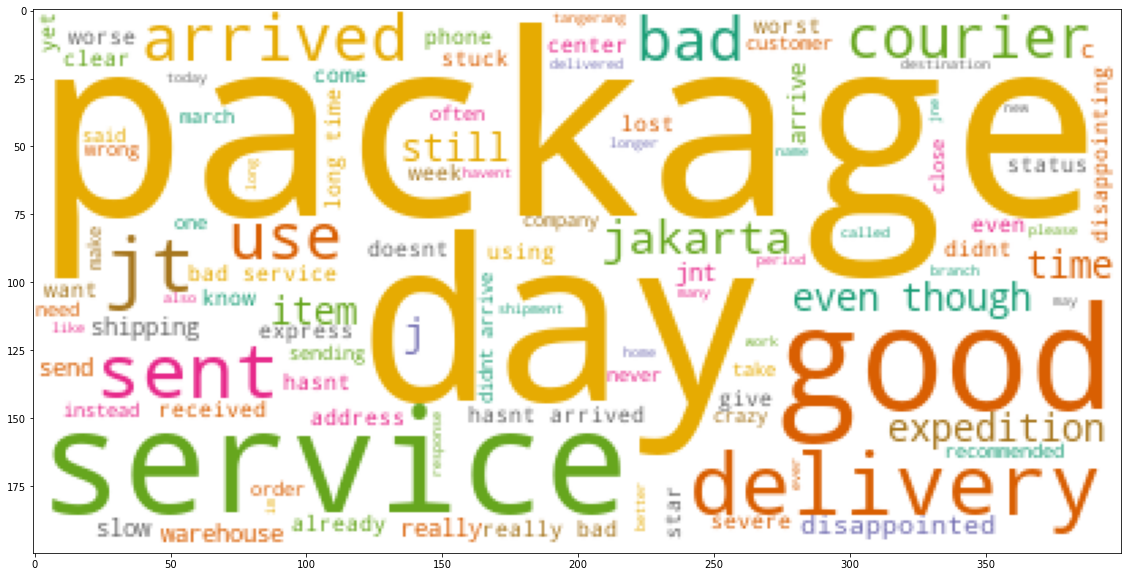

In [16]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)

In [17]:
late_words = ['slow', 'late', 'long']
df_late = df_neg[df_neg['clean_2'].str.contains('|'.join(late_words))]
df_late = df_late.rename(columns ={'clean_2':'Late reviews'})

In [18]:
df_late

,Late reviews
1,worst worst use courier youll regret later unp...
5,slow work item ordered still even delivery att...
7,delivery service clear irritates sender recipi...
19,competitor often late delivery estimation prob...
20,almost month package say delivery courier anja...
...,...
721,waiter good slow expensive
724,sending fellow jakarta arrived day hellooowww ...
733,recommended many day arrived j t long time cou...
759,shouldnt need give star long delivery time arr...


In [19]:
df_late.to_csv('Late_reviews_jnt.csv')